# Logistic Regression with Python Assignment: Titanic Dataset
>**Source:** Datasets used are from the [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic/data) Kaggle Competition page. 

### Introduction and Task Details
The goal is to find patterns in train.csv that help predict whether the passengers in test.csv survived. This will be done using logistic regression and other relevant machine learning techniques. 

**Contents**
1. [Getting the imports and data](#importing-python-packages-and-datasets)
    * [Unclear column names explained](#unclear-column-names-explained)
2. [Assessing the quality of the data](#data-quality-assessment)
3. [Preparing the data for analysis](#data-preprocessing)
    * [Handling missing data](#resolving-missing-values)
        * [Cabin missing values](#cabin-missing-values)
        * [Age missing values](#age-missing-values)
        * [Embarked missing values](#embarked-missing-values)
    * [Reassessing the quality of the data](#reassess-the-data-quality)
    * [Converting categorical variables with one-hot encoding](#one-hot-encoding)
    * [Apply changes to the test data](#apply-changes-to-the-test-data-too)
4. [Exploring the data visually](#visual-exploratory-data-analysis)
5. [Logistic Regression analysis](#logistic-regression)

### Importing Python Packages and Datasets

The first step is to import all the relevant packages such as numpy (for array management), pandas (for dataframes), sklearn (for preprocessing), matplotlib (for visually plotting data) and seaborn (for more data visualisations).

In [1]:
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import warnings
warnings.simplefilter(action='ignore')
from subprocess import call
from IPython.display import Image
import category_encoders as ce

Now it's time to load in the csv files with all the relevant data for this task (train and test) as dataframes using pandas. 

In [2]:
train_df = pd.read_csv("train.csv")

test_df = pd.read_csv("test.csv")

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Unclear column names explained

SibSp is number of Siblings or Spouses

Parch is number of Parents or Children

Embarked, The Titanic made stops at the following locations, the letters in the embarked column refer to the first letter of the city name.
- Cherbourg, France
- Southampton, England
- Queenstown, Ireland (now Cobh)



In [3]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Data Quality Assessment

To see the size of the traing data:

In [4]:
train_df.shape # 891 rows/samples, 12 columns 

(891, 12)

To see the size of the test data:

In [5]:
test_df.shape # 418 rows/samples, 11 columns (survival column is removed since it's what we want to predict) 

(418, 11)

Find out about the data types, missing values, and general counts for the training data to see how much preprocessing is required. 

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Find out the exact number of missing/null values in each column.

In [7]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Overview of the Training Data**
- Name, Sex, Ticket, Cabin and Embarked are all object types
- Age, Cabin and Embarked have missing/null values
- Age has 177 missing values, Cabin has 687 missing values, Embarked has 2 missing values
- The data currently has 12 features (columns)

**How to Address the Issues**
- Use one-hot encoding on some of the object data type features, as long as they don't contain too many unique values. Name, Ticket, Cabin will be excluded from this process due to high cardinality.
- Attempt to use the [Top 10 Trick](https://medium.com/@jjosephmorrison/one-hot-encoding-to-set-up-categorical-features-for-linear-regression-6bac35661bb6) to find top 10 most common unique values for the Cabin column. Make sure to exclude Nan values as they will skew the top 10. 
- For the missing/null values in Age and Embarked, plot normal distributions to see if it is appropriate to fill in missing values with average values. If not appropriate to use mean values, impute with median or mode.

### Data Preprocessing

#### Resolving missing values

##### Cabin missing values

In [8]:
# Remove Nan Cabin values values by replacing with empty value
train_df["Cabin"] = train_df["Cabin"].fillna(value="")
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


The NaN values in Cabin have been successfully removed, as can be seen above. This prevents Embarked Nan from being considered a Top 10 feature later on when one-hot encoding is performed (originally Embarked Nan would have been the number 1 feature in Top 10 because NaN is the most common value for Embarked). 

##### Age missing values

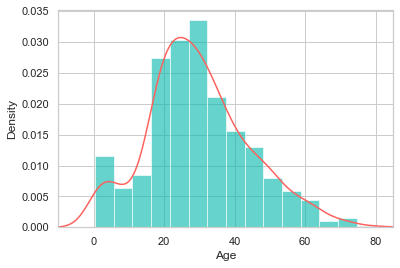

In [9]:
# Plot a normal distribution for Age
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='#01b8aa', alpha=0.6)
train_df["Age"].plot(kind='density', color='#fd625e')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

The histogram plot above shows a right-skew indicating that more of the passengers were from the older age categories. This makes some sense as it would be expected that more adults were aboard than children and teenagers. Using a median value for data imputation removes the effect of this skew. To demonstrate the skew, both the mean and median have been calculated. As expected, the mean value is higher than the median value.  

In [10]:
# Calculate the mean Age 
print('The mean "Age" of the passengers is %.2f' %(train_df["Age"].mean(skipna=True)))

# Calculate the median Age
print('The median "Age" of the passengers is %.2f' %(train_df["Age"].median(skipna=True)))

The mean "Age" of the passengers is 29.70
The median "Age" of the passengers is 28.00


In [11]:
# Fill in missing age values with median age of 28.00
train_df["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)

##### Embarked missing values 

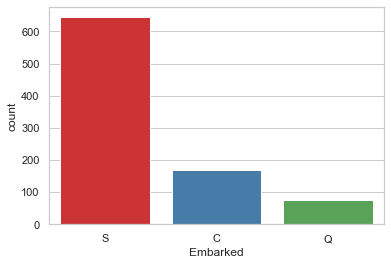

Most passengers boarded the Titanic from S (Southampton).


In [12]:
# Plot a bar chart to see mode value for Embarked by comparing counts of each boarding point
sns.countplot(x='Embarked', data=train_df, palette='Set1')
plt.show()
print('Most passengers boarded the Titanic from %s (Southampton).' %train_df['Embarked'].value_counts().idxmax())

The bar chart above shows Southampton as the most common boarding point for passengers of the Titanic. As such, the 2 missing values for embarked will be filled with S for Southampton.

In [13]:
# Impute missing values with S
train_df["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)

#### Reassess the data quality

Once again, the data is being assessed for its data type composition, missing values, and general counts. At this point, we expect to see no null values in any category and the data type composition should have remained the same. 

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [15]:
train_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

#### One-Hot Encoding

In [16]:
# Bug: sometimes this cell only displays output properly when run twice
# Configure data frme setting so that all new features can be seen after encoding
pd.set_option('display.max_columns', 25)

# Use Top 10 trick to reduce cardinality of Cabin column
top10 = train_df["Cabin"].value_counts()[:10].index
train_df.loc[~train_df["Cabin"].isin(top10), "Cabin"] = "OTHER"

#Drop high cardinality columns for now
t_df = train_df.drop(columns=["Name", "Ticket"])

# Perform one-hot encoding on reduced version of train_df
encoder = ce.OneHotEncoder(use_cat_names=True)
t_df_encoded = encoder.fit_transform(t_df)

t_df_encoded

,PassengerId,Survived,Pclass,Sex_male,Sex_female,Age,SibSp,Parch,Fare,Cabin_,Cabin_OTHER,Cabin_G6,Cabin_C23 C25 C27,Cabin_F33,Cabin_E101,Cabin_F2,Cabin_D,Cabin_C22 C26,Cabin_B96 B98,Cabin_B20,Embarked_S,Embarked_C,Embarked_Q
0,1,0,3,1,0,22.0,1,0,7.2500,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,1,1,0,1,38.0,1,0,71.2833,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,3,1,3,0,1,26.0,0,0,7.9250,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,1,1,0,1,35.0,1,0,53.1000,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,5,0,3,1,0,35.0,0,0,8.0500,1,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,0,27.0,0,0,13.0000,1,0,0,0,0,0,0,0,0,0,0,1,0,0
887,888,1,1,0,1,19.0,0,0,30.0000,0,1,0,0,0,0,0,0,0,0,0,1,0,0
888,889,0,3,0,1,28.0,1,2,23.4500,1,0,0,0,0,0,0,0,0,0,0,1,0,0
889,890,1,1,1,0,26.0,0,0,30.0000,0,1,0,0,0,0,0,0,0,0,0,0,1,0


Sex, Cabin and Embarked have successfully been encoded. Sex has been split into 2 new columns called Sex_male and Sex_female. Cabin has been split into its top 10 features with all other features grouped into Cabin_OTHER. Embarked has been split into 3 columns called Embarked_S, Embarked_C and Embarked_Q.  
**NB:** Cabin_ will be dropped as it appears to be an inverted duplicate of Cabin_OTHER.

In [17]:
t_df_encoded = t_df_encoded.drop(columns=['Cabin_'])
t_df_encoded # The final 'cleaned' version of the training data to use from now on  

,PassengerId,Survived,Pclass,Sex_male,Sex_female,Age,SibSp,Parch,Fare,Cabin_OTHER,Cabin_G6,Cabin_C23 C25 C27,Cabin_F33,Cabin_E101,Cabin_F2,Cabin_D,Cabin_C22 C26,Cabin_B96 B98,Cabin_B20,Embarked_S,Embarked_C,Embarked_Q
0,1,0,3,1,0,22.0,1,0,7.2500,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,1,1,0,1,38.0,1,0,71.2833,1,0,0,0,0,0,0,0,0,0,0,1,0
2,3,1,3,0,1,26.0,0,0,7.9250,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,1,1,0,1,35.0,1,0,53.1000,1,0,0,0,0,0,0,0,0,0,1,0,0
4,5,0,3,1,0,35.0,0,0,8.0500,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,0,27.0,0,0,13.0000,0,0,0,0,0,0,0,0,0,0,1,0,0
887,888,1,1,0,1,19.0,0,0,30.0000,1,0,0,0,0,0,0,0,0,0,1,0,0
888,889,0,3,0,1,28.0,1,2,23.4500,0,0,0,0,0,0,0,0,0,0,1,0,0
889,890,1,1,1,0,26.0,0,0,30.0000,1,0,0,0,0,0,0,0,0,0,0,1,0


In [33]:
# Final assess
t_df_encoded.isnull().sum()

PassengerId          0
Survived             0
Pclass               0
Sex_male             0
Sex_female           0
Age                  0
SibSp                0
Parch                0
Fare                 0
Cabin_OTHER          0
Cabin_G6             0
Cabin_C23 C25 C27    0
Cabin_F33            0
Cabin_E101           0
Cabin_F2             0
Cabin_D              0
Cabin_C22 C26        0
Cabin_B96 B98        0
Cabin_B20            0
Embarked_S           0
Embarked_C           0
Embarked_Q           0
dtype: int64

##### Apply changes to the test data too

In [18]:
# Remove Nan Cabin values values by replacing with empty value
test_df["Cabin"] = test_df["Cabin"].fillna(value="")
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,,S


In [19]:
# Fill in missing age values with median age of 28.00
test_df["Age"].fillna(test_df["Age"].median(skipna=True), inplace=True)

In [20]:
# Impute missing values with S
test_df["Embarked"].fillna(test_df['Embarked'].value_counts().idxmax(), inplace=True)

In [21]:
# Assess test data quality
test_df.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin          0
Embarked       0
dtype: int64

In [22]:
# Impute missing fare value with median because price related metrics tend to skew in favour of the richer contributors (only a few very high fares needed to skew mean fare value)
test_df["Fare"].fillna(test_df["Fare"].median(skipna=True), inplace=True)

In [23]:
# Reassess test data quality
test_df.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [24]:
# Configure data frme setting so that all new features can be seen after encoding
pd.set_option('display.max_columns', 25)

# Use Top 10 trick to reduce cardinality of Cabin column
test_top10 = test_df["Cabin"].value_counts()[:10].index
test_df.loc[~test_df["Cabin"].isin(test_top10), "Cabin"] = "OTHER"

#Drop high cardinality columns for now
te_df = test_df.drop(columns=["Name", "Ticket"])

# Perform one-hot encoding on reduced version of train_df
encoder = ce.OneHotEncoder(use_cat_names=True)
te_df_encoded = encoder.fit_transform(te_df)
te_df_encoded = te_df_encoded.drop(columns=['Cabin_'])

te_df_encoded # the final version of the test data to use from now on

,PassengerId,Pclass,Sex_male,Sex_female,Age,SibSp,Parch,Fare,Cabin_OTHER,Cabin_B57 B59 B63 B66,Cabin_C31,Cabin_C23 C25 C27,Cabin_C101,Cabin_C55 C57,Cabin_C116,Cabin_C80,Cabin_C89,Cabin_A34,Embarked_Q,Embarked_S,Embarked_C
0,892,3,1,0,34.5,0,0,7.8292,0,0,0,0,0,0,0,0,0,0,1,0,0
1,893,3,0,1,47.0,1,0,7.0000,0,0,0,0,0,0,0,0,0,0,0,1,0
2,894,2,1,0,62.0,0,0,9.6875,0,0,0,0,0,0,0,0,0,0,1,0,0
3,895,3,1,0,27.0,0,0,8.6625,0,0,0,0,0,0,0,0,0,0,0,1,0
4,896,3,0,1,22.0,1,1,12.2875,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,0,27.0,0,0,8.0500,0,0,0,0,0,0,0,0,0,0,0,1,0
414,1306,1,0,1,39.0,0,0,108.9000,1,0,0,0,0,0,0,0,0,0,0,0,1
415,1307,3,1,0,38.5,0,0,7.2500,0,0,0,0,0,0,0,0,0,0,0,1,0
416,1308,3,1,0,27.0,0,0,8.0500,0,0,0,0,0,0,0,0,0,0,0,1,0


In [32]:
# Final assess
te_df_encoded.isnull().sum()

PassengerId              0
Pclass                   0
Sex_male                 0
Sex_female               0
Age                      0
SibSp                    0
Parch                    0
Fare                     0
Cabin_OTHER              0
Cabin_B57 B59 B63 B66    0
Cabin_C31                0
Cabin_C23 C25 C27        0
Cabin_C101               0
Cabin_C55 C57            0
Cabin_C116               0
Cabin_C80                0
Cabin_C89                0
Cabin_A34                0
Embarked_Q               0
Embarked_S               0
Embarked_C               0
dtype: int64

### Visual Exploratory Data Analysis

As per the [Titanic dataset tutorial](https://www.kaggle.com/alexisbcook/titanic-tutorial) on Kaggle, the survival rate of men vs women has been calculated below.

In [25]:
women = train_df.loc[train_df.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [26]:
men = train_df.loc[train_df.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


#### Feature Selection and Correlations

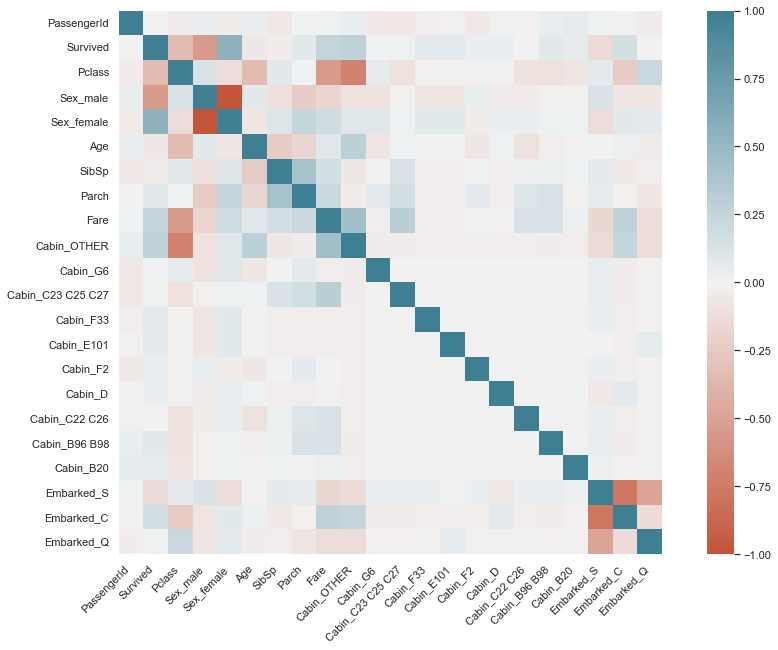

In [27]:
# Plot general correlation heatmap to get overview of correlating features using our encoded training data

plt.figure(figsize=(16,10))

corr = t_df_encoded.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

**Initial takeaways relating to survival**
* Pclass has slightly negative correlation with survival, a higher Pclass number correlates to lower survival. Being 3rd class passenger negativey correlates to survival.
* Sex_male shows negative correlation with survival (as expected given the earlier survival rate calculation for male passengers)
* Sex_female shows positive correlation with survival (as expected given the earlier survival rate calculation for female passengers)

**Taking a closer look at correlations related to survival**

<AxesSubplot:>

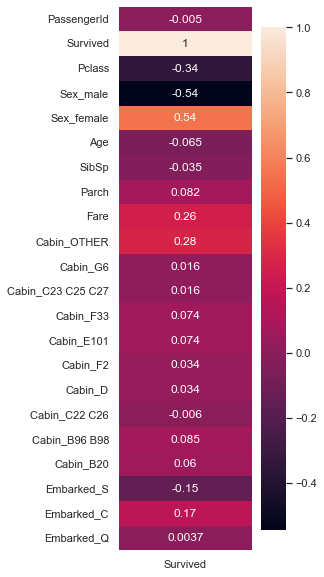

In [28]:
survived_corr =  t_df_encoded.corr().loc[:,['Survived']]
plt.figure(figsize = (3,10))
sns.heatmap(survived_corr,annot = True)

**Key Takeaways**
* Pclass has slightly negative correlation with survival
* Sex_male has negative correlation with survival 
* Sex_female has positive correlation
* Fare has slight positive correlation to survival
* Cabin_C22 C26 is the only Cabin showing negative correlation to survival (though this is very small) 
* Embarked_S has a slightly negative correlation to survival and is the only Embarked with a negative correlation (this may be in part due to the fact that the majority of passengers embarked here)

### Logistic Regression 

**Source:** Baligh Mnassr's [Kaggle Notebook](https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python/notebook)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Select columns of interest and set X and y 
cols = ["Sex_male", "Age", "Fare", "SibSp", "Parch", "Pclass","Cabin_C23 C25 C27", "Embarked_C","Embarked_S"] 
X = t_df_encoded[cols]
y = t_df_encoded['Survived']

# Build the logistic regression model and compute the feature importances
model = LogisticRegression()

# Create the Recursive Feature Elimination Model and select 8 attributes
rfe = RFE(model, 8)
rfe = rfe.fit(X, y)

# Summarise the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['Sex_male', 'Age', 'SibSp', 'Parch', 'Pclass', 'Cabin_C23 C25 C27', 'Embarked_C', 'Embarked_S']


Optimal number of features: 8
Selected features: ['Sex_male', 'Age', 'SibSp', 'Parch', 'Pclass', 'Cabin_C23 C25 C27', 'Embarked_C', 'Embarked_S']


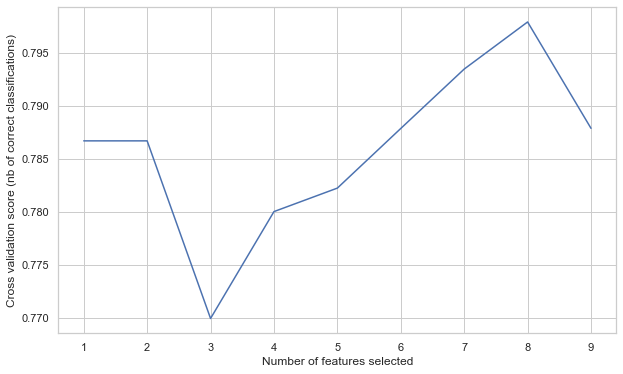

In [44]:
# Feature ranking with recursive feature elimination and cross-validation

from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

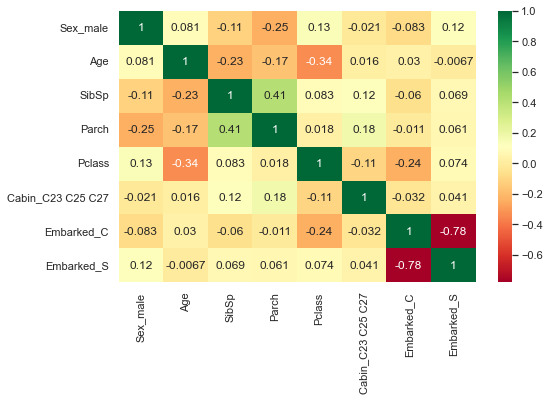

In [49]:
Selected_features = ['Sex_male', 'Age', 'SibSp', 'Parch', 'Pclass', 'Cabin_C23 C25 C27', 'Embarked_C', 'Embarked_S']

X = t_df_encoded[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

Train/Test split results:
LogisticRegression accuracy is 0.788
LogisticRegression log_loss is 0.510
LogisticRegression auc is 0.829


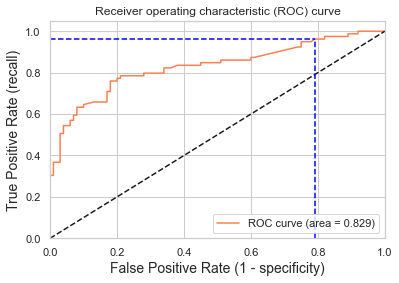

Using a threshold of 0.073 guarantees a sensitivity of 0.962 and a specificity of 0.210, i.e. a false positive rate of 79.00%.


In [50]:
# Add more imports  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

X = t_df_encoded[Selected_features]
y = t_df_encoded['Survived']

# Split the data using train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#Define simple model

C = np.arange(1e-05, 5.5, 0.1)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}
log_reg = LogisticRegression()

#Simple pre-processing estimators

std_scale = StandardScaler(with_mean=False, with_std=False)
#std_scale = StandardScaler()

#Defining the CV method: Using the Repeated Stratified K Fold


n_folds=5
n_repeats=5

rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=2)

#Creating simple pipeline and defining the gridsearch


log_clf_pipe = Pipeline(steps=[('scale',std_scale), ('clf',log_reg)])

log_clf = GridSearchCV(estimator=log_clf_pipe, cv=rskfold,
              scoring=scoring, return_train_score=True,
              param_grid=dict(clf__C=C), refit='Accuracy')

log_clf.fit(X, y)
results = log_clf.cv_results_


In [52]:
te_df_encoded['Survived'] = log_clf.predict(te_df_encoded[Selected_features])
te_df_encoded['PassengerId'] = test_df['PassengerId']

submission = te_df_encoded[['PassengerId','Survived']]

submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## Other Machine Learning Techniques

### Random Forest and Decision Trees

In [30]:
y = train_df["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_df[features])
X_test = pd.get_dummies(test_df[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)


>**Source:** [How to Visualise a Decision Tree](https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c)

In [31]:
# estimator = model.estimators_[50]
# # Export as dot file
# export_graphviz(estimator, out_file='tree.dot', 
#                 # feature_names = train_df.feature_names,
#                 # class_names = train_df.target_names,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
# # Display in jupyter notebook
# Image(filename = 'tree.png')